In [21]:
import warnings
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss

warnings.filterwarnings("ignore")
plt.style.use("dark_background")

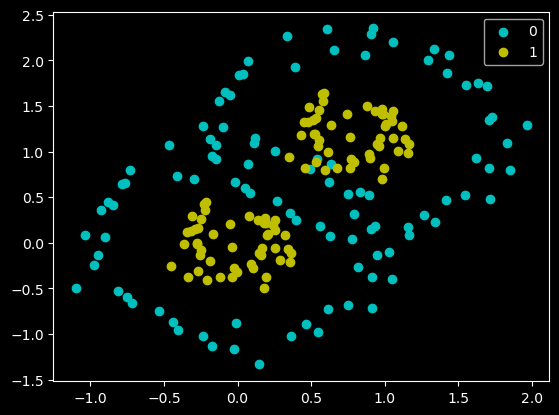

In [22]:
X, y = make_circles(n_samples=100, noise=0.1, factor=0.3, random_state=0)

X_new = X + np.array([0.8, 1.2])
X = np.concatenate([X, X_new])

y = np.concatenate([y, y])
y = y.reshape(-1, 1)

X_0 = X[np.where(y == 0)[0]]
X_1 = X[np.where(y == 1)[0]]

plt.scatter(X_0[:, 0], X_0[:, 1], c="c", label=0)
plt.scatter(X_1[:, 0], X_1[:, 1], c="y", label=1)

plt.legend()
plt.grid(False)
plt.show()

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

X_train = X_train.T
X_test = X_test.T
y_train = y_train.T
y_test = y_test.T

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2, 150), (2, 50), (1, 150), (1, 50))

In [24]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

In [25]:
def initialization(n_nodes: tuple[int], seed=None):
    np.random.seed(seed)
    
    parameters = {}
    weights = {f"W{i+1}": np.random.randn(n_nodes[i+1], n_nodes[i]) for i in range(len(n_nodes) - 1)}
    biases = {f"b{i+1}": np.random.randn(n_nodes[i+1], 1) for i in range(len(n_nodes) - 1)}
    
    parameters.update(weights)
    parameters.update(biases)

    return parameters

def forward_propagation(X, parameters):
    A = X[:]
    activations = {"A0": X}
    
    for i in range(len(parameters) // 2):
        W = parameters[f"W{i+1}"]
        b = parameters[f"b{i+1}"]
        
        Z = W.dot(A) + b
        A = sigmoid(Z)
        activations[f"A{i+1}"] = A

    return activations

def back_propagation(X, y, parameters, activations):
    m = y.shape[1]
    n = len(activations) - 1
    
    gradients = {}
    dZ = activations[f"A{n}"] - y

    for i in range(n, 0, -1):
        gradients[f"dW{i}"] = 1 / m * dZ.dot(activations[f"A{i-1}"].T)
        gradients[f"db{i}"] = 1 / m * np.sum(dZ, axis=1, keepdims=True)
        
        dZ = parameters[f"W{i}"].T.dot(dZ) * activations[f"A{i-1}"] * (1 - activations[f"A{i-1}"])

    return gradients

def update(parameters, gradients, learning_rate):
    for k in parameters.keys():
        parameters[k] = parameters[k] - learning_rate * gradients[f"d{k}"]
    
    return parameters

def predict(X, parameters):
    activations = forward_propagation(X, parameters)
    last_activation = sorted(list(activations.keys()))[-1]
    
    return activations[last_activation] >= 0.5

In [26]:
def neural_network(X_train, y_train, X_test=None, y_test=None, n_nodes_intermediate=None, seed=None, learning_rate=0.1, n_iter=100):
    n_nodes_intermediate.insert(0, X_train.shape[0])
    n_nodes_intermediate.append(y_train.shape[0])
    n_nodes = tuple(n_nodes_intermediate)
    parameters = initialization(n_nodes, seed=seed)
    last_layer = len(n_nodes) - 1
    
    parameters_list = [[parameters[f"W{last_layer}"][:, 0], parameters[f"W{last_layer}"][:, 1]]]
    train_loss = []
    train_acc = []
    if X_test is not None:
        test_loss = []
        test_acc = []
    
    for i in tqdm(range(n_iter)):
        activations_train = forward_propagation(X_train, parameters)
        gradients_train = back_propagation(X_train, y_train, parameters, activations_train)
        
        if X_test is not None:
            activations_test = forward_propagation(X_test, parameters)
            
        parameters = update(parameters, gradients_train, learning_rate)

        if i % 10 == 0:
            parameters_list.append([parameters[f"W{last_layer}"][:, 0], parameters[f"W{last_layer}"][:, 1]])

            train_loss.append(log_loss(y_train, activations_train[f"A{last_layer}"]))
            y_train_pred = predict(X_train, parameters)
            current_train_accuracy = accuracy_score(y_train.flatten(), y_train_pred.flatten())
            train_acc.append(current_train_accuracy)
            
            if X_test is not None:
                test_loss.append(log_loss(y_test, activations_test[f"A{last_layer}"]))
                y_test_pred = predict(X_test, parameters)
                current_test_accuracy = accuracy_score(y_test.flatten(), y_test_pred.flatten())
                test_acc.append(current_test_accuracy)

    if len(parameters_list) > 10:
        parameters_list = np.array(parameters_list)[np.linspace(0, len(parameters_list) - 1, 10).astype(int)].reshape(10, -1)
    
    W_1_list = parameters_list[:, 0]
    W_2_list = parameters_list[:, 1]

    fontdict = {
        "fontsize": 16,
        "fontweight": "bold"
    }

    plt.figure(figsize=(12, 8))

    # Loss
    plt.subplot(2, 2, 1)
    plt.plot(train_loss, label="train loss")
    if X_test is not None:
        plt.plot(test_loss, label="test loss")
    plt.gca().set_xticklabels([int(x * 10) for x in plt.gca().get_xticks()])
    plt.xlabel("n_iter")
    plt.ylabel("Loss")
    plt.title("Log loss", fontdict=fontdict)
    plt.legend()

    # Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(train_acc, label="train acc")
    if X_test is not None:
        plt.plot(test_acc, label="test acc")
    plt.gca().set_xticklabels([int(x * 10) for x in plt.gca().get_xticks()])
    plt.xlabel("n_iter")
    plt.ylabel("Accuracy")
    plt.title("Accuracy score", fontdict=fontdict)
    plt.legend()

    # Gradient descent
    plt.subplot(2, 2, 3)
    
    n = 100
    W_1 = np.linspace(W_1_list.min() - 2, W_1_list.max() + 2, n)
    W_2 = np.linspace(W_2_list.min() - 2, W_2_list.max() + 2, n)
    W_1, W_2 = np.meshgrid(W_1, W_2)
    
    W_final = np.c_[W_1.ravel(), W_2.ravel(), *[np.full(n*n, x) for x in parameters[f"W{last_layer}"][:, 2:].ravel()]]
    A = activations_train[f"A{last_layer - 1}"]
    b = parameters[f"b{last_layer}"]
    Z = W_final.dot(A) + b
    A = 1 / (1 + np.exp(-Z))
    epsilon = 1e-15
    L = -1 / A.shape[1] * np.sum(y_train * np.log(A + epsilon) + (1 - y_train) * np.log(1 - A + epsilon), axis=1).reshape(W_1.shape)
    
    plt.contourf(W_1, W_2, L, cmap="ocean_r")
    plt.colorbar()
    
    plt.scatter(parameters_list[0, 0], parameters_list[0, 1], s=50, marker="x", c="#F1E5D1", label="Start")
    plt.scatter(parameters_list[1, 0], parameters_list[1, 1], s=50, marker="x", c="#C39898", label="Interm.")
    for i, (W_1, W_2) in enumerate(parameters_list[2:-1]):
        plt.scatter(W_1, W_2, s=50, marker="x", c="#C39898")
    plt.scatter(parameters_list[-1, 0], parameters_list[-1, 1], s=50, marker="x", c="#6F4E37", label="End")
    
    plt.xlabel("$w_{n,1}$")
    plt.ylabel("$w_{n,2}$")
    plt.title("Gradient descent", fontdict=fontdict)
    plt.legend()

    # Decision boundary and points
    plt.subplot(2, 2, 4)

    ## Decision boundary
    X = np.c_[X_train, X_test]
    y = np.c_[y_train, y_test]
    X1 = np.linspace(X[0, :].min() - 0.2, X[0, :].max() + 0.2, 100)
    X2 = np.linspace(X[1, :].min() - 0.2, X[1, :].max() + 0.2, 100)
    X1, X2 = np.meshgrid(X1, X2)
    points = np.c_[X1.ravel(), X2.ravel()]

    Z = forward_propagation(points.T, parameters)
    ZA2 = Z[f"A{last_layer}"].reshape(X1.shape)

    plt.contourf(X1, X2, ZA2, levels=[0, 0.5, 1], colors=["c", "y"], alpha=0.4)
    plt.contour(X1, X2, ZA2, levels=[0.5], colors="r", linewidths=3)
    
    # Points
    X_0 = X.T[np.where(y == 0)[1]].T
    X_1 = X.T[np.where(y == 1)[1]].T
    
    plt.scatter(X_0[0, :], X_0[1, :], c="c", label=0)
    plt.scatter(X_1[0, :], X_1[1, :], c="y", label=1)
    
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title("Boundary decision", fontdict=fontdict)
    plt.legend()
    plt.grid(False)
    
    plt.tight_layout()
    plt.show()

    return parameters

100%|██████████| 5000/5000 [00:01<00:00, 3193.39it/s]


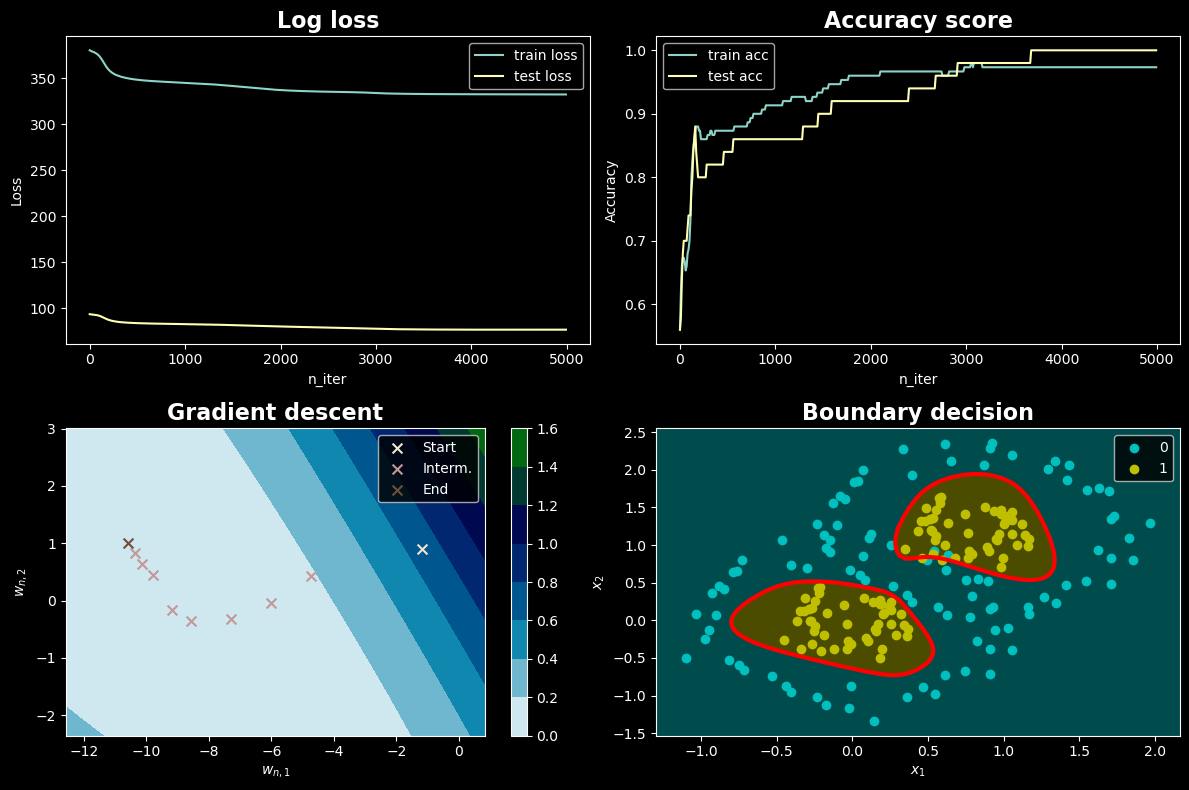

In [27]:
parameters = neural_network(X_train, y_train, X_test, y_test, n_nodes_intermediate=[8, 8], seed=0, learning_rate=1, n_iter=5000)